In [3]:
import cv2
import numpy as np
import os
from pycocotools import mask as mask_utils
import xml.etree.ElementTree as ET
import pathlib
from PIL import Image
import json
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, label

### Funzioni utili


In [4]:
def get_items(root, ids):
    images = []
    all_boxes = []
    all_masks = []
    all_labels = []

    for image_id in ids:
        image = _get_images(root, image_id)
        boxes, labels = _get_annotations(root, image_id)
        masks = _get_masks(root, image_id)

        images.append(image)
        all_boxes.append(boxes)
        all_masks.append(masks)
        all_labels.append(labels)

    return images, all_boxes, all_masks, all_labels


def _read_image_ids(image_sets_file):
    ids = []
    with open(image_sets_file) as f:
        for line in f:
            ids.append(line.rstrip())
    return ids


def _get_images(root, image_id):
    image_file = os.path.join(root, "JPEGImages", image_id + ".jpg")
    image = cv2.imread(str(image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def _get_masks(root, image_id):
    mask_file = os.path.join(root, "SegmentationClass", image_id + ".png")
    mask_array = np.array(Image.open(mask_file))
    unique_values = np.unique(mask_array)
    masks = {}

    for value in unique_values:
        if value in [0, 255]:
            # If the value is 0 or 255, add it to the mask for 0
            _ = masks.get(0, np.zeros_like(mask_array)) | (mask_array == value)
        else:
            # Apply binary dilation before finding connected components
            dilated_mask = binary_dilation(mask_array == value)
            labeled_array, num_features = label(dilated_mask)
            for i in range(1, num_features + 1):
                masks[f"{value}_{i}"] = np.where(labeled_array == i, 1, 0)

    rle_masks = {}
    for key, value in masks.items():
        rle = mask_utils.encode(np.asfortranarray(value.astype(np.uint8)))
        rle["counts"] = rle["counts"].decode("utf-8")  # Convert bytes to string
        rle_masks[key] = rle

    return rle_masks


def _get_annotations(root, image_id):
    annotation_file = os.path.join(root, "Annotations", image_id + ".xml")
    objects = ET.parse(annotation_file).findall("object")
    boxes = []
    labels = []

    for object in objects:
        class_name = object.find("name").text.lower().strip()
        bbox = object.find("bndbox")
        x1 = float(bbox.find("xmin").text) - 1
        y1 = float(bbox.find("ymin").text) - 1
        x2 = float(bbox.find("xmax").text) - 1
        y2 = float(bbox.find("ymax").text) - 1
        boxes.append([x1, y1, x2, y2])
        labels.append(class_name)

    # return bbox y labels
    return (np.array(boxes, dtype=np.float32), np.array(labels))


# create the ids for images
root = pathlib.Path("/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012")
images_file = os.path.join(root, "ImageSets", "Segmentation", "dataset.txt")
ids = _read_image_ids(images_file)
print(len(ids))

11652


### Generazione items dataset


In [5]:
images, boxes, polygons, labels = get_items(root, ids)  # time consuming: 2.46 minuti

### JSON Formatting


In [6]:
instances_voc12 = {
    "info": {
        "description": "VOC 2012 Dataset Annotations files",
        "version": "1.0",
        "year": 2024,
        "contributor": "CILAB",
        "date_created": "02/01/2024",
    },
    "images": [
        # {
        #     "file_name": "2007_000032",
        #     "url": "VOC2012/JPEGImages/2007_000032.jpg",
        #     "height": 281,
        #     "width": 500,
        #     "id": 0,
        # },
        # {...},
    ],
    "annotations": [
        # {
        #     "segmentation": [
        #         [
        #             [117.0, 89.0],
        #             [116.0, 90.0],
        #             [109.0, 90.0],
        #             [107.0, 92.0],
        #             [134.0, 171.0],
        #             [128.0, 171.0],
        #             [127.0, 170.0],
        #             [127.0, 137.0],
        #         ]
        #     ],
        #     "area": 20098.5,
        #     "image_id": 40,
        #     "bbox": [118.0, 176.0, 330.0, 277.0],
        #     "category_id": 9,
        #     "id": 64,
        # },
        # {...},
    ],
    "categories": [
        # {"id": 0, "name": "sheep"},
        # {"id": 1, "name": "bird"},
        # {"id": 2, "name": "bus"},
        # {"id": 3, "name": "cow"},
    ],
}
instances_voc12

{'info': {'description': 'VOC 2012 Dataset Annotations files',
  'version': '1.0',
  'year': 2024,
  'contributor': 'CILAB',
  'date_created': '02/01/2024'},
 'images': [],
 'annotations': [],
 'categories': []}

### Function to create lvis style annotations for voc12


In [10]:
def create_lvis_style_annotation(ids, images, boxes, rle_masks, labels, annotations):
    # generate set of categories
    annotations_images = []
    annotations_segmentations = []

    annotations_categories = [
        {"id": i, "name": name} for i, name in enumerate(set(np.concatenate(labels)))
    ]
    category_to_id = {
        category["name"]: category["id"] for category in annotations_categories
    }

    for enum, id_ in enumerate(ids):
        # print(ids[i])
        image = {
            "file_name": id_,  # This is the only field that is compulsory
            "url": f"JPEGImages/{id_}.jpg",
            "height": images[enum].shape[0],
            "width": images[enum].shape[1],
            "id": enum,
        }
        annotations_images.append(image)

    i = 0
    for enum, (box, rle, label) in enumerate(zip(boxes, rle_masks, labels)):
        for b, (_, rle_value), l in zip(box, rle.items(), label):
            annotation = {
                "segmentation": rle_value["counts"],
                "area": int(mask_utils.area(rle_value)),
                "image_id": enum,
                "bbox": b.tolist(),  # Assuming box is a list/array of [x_min, y_min, x_max, y_max]
                "category_id": category_to_id[l],
                "id": i,
            }
            annotations_segmentations.append(annotation)
            i += 1

    annotations["images"] = annotations_images
    annotations["annotations"] = annotations_segmentations
    annotations["categories"] = annotations_categories
    return annotations

In [11]:
# generate file, if you want to use it in the future
annotations = create_lvis_style_annotation(
    ids, images, boxes, polygons, labels, instances_voc12
)

In [ ]:
int(
    mask_utils.area(
        {
            "size": [281, 500],
            "counts": "[cT11f84M2N2N101N100000O010O10000000000003M1O1O1O00O1O1LhGFY8:2011O1O1O1O00000O10O1O1O1O1O10000000O10O100000O0M4O001O1O0O2O000001O2H8I7NoQc2",
        }
    )
),

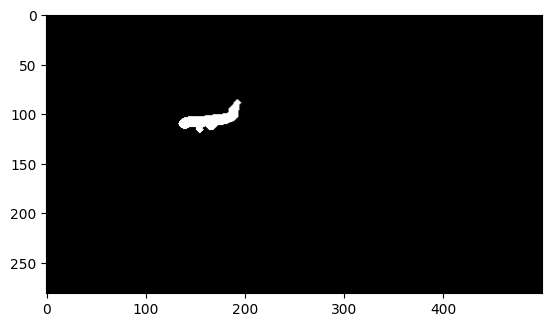

In [23]:
binary_mask = mask_utils.decode(rle)

plt.imshow(binary_mask, cmap="gray")
plt.show()

In [12]:
for k, v in annotations.get("annotations")[0].items():
    print(k, type(v))

segmentation <class 'str'>
area <class 'int'>
image_id <class 'int'>
bbox <class 'list'>
category_id <class 'int'>
id <class 'int'>


### Save file json


In [17]:
with open("instances_voc12.json", "w") as file:
    json.dump(annotations, file)

In [4]:
data = {
    "license": 4,
    "file_name": "000000397133.jpg",
    "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
    "height": 427,
    "width": 640,
    "date_captured": "2013-11-14 17:02:52",
    "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
    "id": 397133,
}
image = {
    "file_name": "2007_000042",
    "url": "JPEGImages/2007_000042.jpg",
    "height": 335,
    "width": 500,
    "id": 3,
}
dataset_path = "/home/emanuele/Dottorato/dataset-vari/VOC12"
(f'{dataset_path}/{image["url"]}')

'/home/emanuele/Dottorato/dataset-vari/VOC12/JPEGImages/2007_000042.jpg'